# Optimization with Reinforcement Learning

In this tutorial, we show how different model types within DrugEx can be optimized under the reinforcement learning framework. The models can be taught to generate compounds according to multiple custom rewards and using several optimization strategies. In this tutorial, we review some of the most important scoring functions and optimization strategies on a simple hypothetical example, which will be focused on searching for selective ligands for the adenosine A3 receptor (A3R). In order to do that, we will build two QSAR models that will predict activity on A3R, but also adenosine A1 receptor (A1R). We will then use predictions from these models to generate compounds more selective towards A3R rather than A1R. In practice, this would be a really difficult task because A3R and A1R receptors have very similar binding sites so it would be really hard to use a purely ligand-based approach like this. However, it will serve us well here for the sake of example.


## QSAR Models 

In this section, we create the QSAR models that will serve as the source of rewards in our reinforcement learning framework. They will be built from selected subsets of the `LIGAND` data set (also used in [finetuning](finetuning.ipynb)):

In [1]:
import pandas as pd

mol_col = 'Smiles'
activity_col = 'pChEMBL_Value'
target_col = 'Target_ChEMBL_ID'
columns = (mol_col, activity_col, target_col)

df = pd.read_csv(
    'jupyter/data/LIGAND_RAW.tsv', 
    na_values=('NA', 'nan', 'NaN'), 
    header=0, 
    sep='\t', 
    usecols=columns
)
df.dropna(subset=[activity_col, target_col], inplace=True)
df.head()

,Smiles,pChEMBL_Value,Target_ChEMBL_ID
0,CCCCn1cc2c(nc(NC(=O)Nc3ccc(Cl)c(Cl)c3)n3nc(-c4...,8.43,CHEMBL256
1,O=C(Cc1ccccc1)Nc1nc2nn(CCc3ccccc3)cc2c2nc(-c3c...,7.35,CHEMBL256
2,O=C(COc1ccccc1)Nc1nc2nn(CCc3ccccc3)cc2c2nc(-c3...,6.52,CHEMBL256
3,CC(C)(C)NC(=O)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c3...,7.19,CHEMBL256
4,COc1ccc(-n2cc3c(n2)c(N)nc2ccccc23)cc1,7.04,CHEMBL256


In [2]:
df.shape

(34575, 3)

We have data for quite a few adenosine receptor subtypes in this set:

In [3]:
df[target_col].value_counts()

CHEMBL240     8915
CHEMBL251     5851
CHEMBL256     5496
CHEMBL226     5069
CHEMBL318     3927
CHEMBL255     2670
CHEMBL302     2113
CHEMBL3360     479
CHEMBL2592      55
Name: Target_ChEMBL_ID, dtype: int64

However, we will only use data for A1R (ID=`CHEMBL318`) and A3R (ID=`CHEMBL256`)

In [4]:
df_a1 = df[df[target_col] == "CHEMBL318"]
df_a3 = df[df[target_col] == "CHEMBL256"]

In [5]:
df_a1.head()

,Smiles,pChEMBL_Value,Target_ChEMBL_ID
54,CCCn1c(=O)n(C)c(=O)c2[nH]c(-c3cccnc3)nc21,7.14,CHEMBL318
56,CC(C)Cn1c(N)nc2c1c(=O)n(CC1CC1)c(=O)n2CC1CC1,5.46,CHEMBL318
65,CCCn1c(=O)c2nc(C34CC5CC(CC3C5)C4)[nH]c2n(CCC)c1=O,9.72,CHEMBL318
70,Nc1nc(OCCc2cccc(Cl)c2)nc2c1ncn2C1O[C@H](CO)[C@...,6.60,CHEMBL318
71,NCCCCCCC(=O)Nc1nc2ccc(Cl)cc2c2nc(-c3ccco3)nn12,6.94,CHEMBL318


In [6]:
df_a3.head()

,Smiles,pChEMBL_Value,Target_ChEMBL_ID
0,CCCCn1cc2c(nc(NC(=O)Nc3ccc(Cl)c(Cl)c3)n3nc(-c4...,8.43,CHEMBL256
1,O=C(Cc1ccccc1)Nc1nc2nn(CCc3ccccc3)cc2c2nc(-c3c...,7.35,CHEMBL256
2,O=C(COc1ccccc1)Nc1nc2nn(CCc3ccccc3)cc2c2nc(-c3...,6.52,CHEMBL256
3,CC(C)(C)NC(=O)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c3...,7.19,CHEMBL256
4,COc1ccc(-n2cc3c(n2)c(N)nc2ccccc23)cc1,7.04,CHEMBL256


### Building the Models

Since this tutorial is only meant for demonstration purposes, we will not perform any further preprocessing of the data and just build two simple random forest models on the raw data:

In [7]:
from drugex.training.scorers.predictors import Predictor
from rdkit import Chem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

def train(df):
    df_transformed = [(Chem.MolFromSmiles(x), y) for x, y in zip(df[mol_col], df[activity_col]) if x and type(x) is str]
    X = Predictor.calc_physchem([x[0] for x in df_transformed])
    y = [x[1] for x in df_transformed]
    
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X, y)
    
    return rf

/home/sichom/software/miniconda/envs/drugex-sandbox/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
rf_a1 = train(df_a1)
rf_a3 = train(df_a3)

This is of course not the proper way of doing things, but a much more complex machine learning worflow could be envisaged here.

### Designating Scoring Functions

Since we now have our models, we can directly wrap them in the `ModelScorer` class, which extends the `Scorer` interface:

In [9]:
from drugex.training.interfaces import Scorer

class ModelScorer(Scorer):
    
    def __init__(self, model, prefix):
        super().__init__()
        self.model = model
        self.prefix = prefix
    
    def getScores(self, mols, frags=None):
        X = Predictor.calc_physchem(mols)
        return self.model.predict(X)
    
    def getKey(self):
        return f"{self.prefix}_{type(self.model)}"
    
scorer_a1 = ModelScorer(rf_a1, 'A1')
scorer_a3 = ModelScorer(rf_a3, 'A2')

Instances of this class serve as scoring functions that are used to calculate the rewards in reinforcement learning. We can show how scoring works on a simple example of caffeine:

In [10]:
scorer_a1(["CN1C=NC2=C1C(=O)N(C(=O)N2C)C"])

array([5.93931476])

In [11]:
scorer_a3(["CN1C=NC2=C1C(=O)N(C(=O)N2C)C"])

array([4.82655833])

We can see that indeed our model for A1R might not be ideal in this case because ChEMBL reports pChEMBL values for caffeine in similar range as for A3R (that is around 4.8).

#### Applying Modifiers

Next, we need to set proper modifiers for the scoring functions to calculate the correct rewards:

In [12]:
from drugex.training.scorers.modifiers import ClippedScore

pad = 3.5
activity_threshold = 6.5

# inactive target
scorer_a1.setModifier(ClippedScore(lower_x=activity_threshold + pad, upper_x=activity_threshold))

# active target
scorer_a3.setModifier(ClippedScore(lower_x=activity_threshold - pad, upper_x=activity_threshold))

In this case we choose the `ClippedScore` function as a modifier. It will change the previous values as follows:

In [13]:
scorer_a1(["CN1C=NC2=C1C(=O)N(C(=O)N2C)C"])

array([1.])

In [14]:
scorer_a3(["CN1C=NC2=C1C(=O)N(C(=O)N2C)C"])

array([0.52187381])

The intent of the modifier becomes clear when we plot the `ClippedScore` function for some example values:

<AxesSubplot:xlabel='Original', ylabel='ClippedScore'>

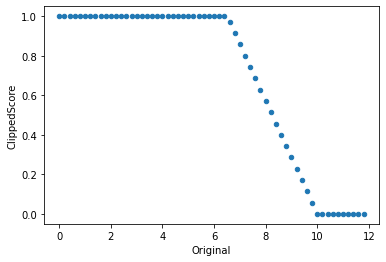

In [15]:
import numpy as np

def depict_modifier(modifier):
    vals = np.arange(0,12, 0.2)
    scores = [(x, modifier(x)) for x in vals] # get the A1R modifier for inactivity (the lower the activity, the higher the reward)
    scores = pd.DataFrame(scores, columns=['Original', 'ClippedScore'])
    return scores.plot.scatter(x = 'Original', y = 'ClippedScore')

depict_modifier(scorer_a1.getModifier())

Theregore, the score starts to deteriorate grafually as we cross the chosen `activity_threshold` above and becomes zero at `activity_threshold + pad`. When we show the same for our 'active' scoring function, the relationship is the exact opposite:

<AxesSubplot:xlabel='Original', ylabel='ClippedScore'>

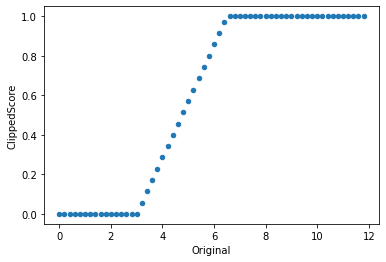

In [16]:
depict_modifier(scorer_a3.getModifier())

Therefore, we reward all molecules with a score above `activity_threshold` with 1.0 and all molecules predicted as inactive with scores below `activity_threshold - pad` get no reward.

In addition to these scores, we also implement two other scoring functions for a desired `logP` range and molecular weight (`MW`):

In [17]:
from drugex.training.scorers.properties import Property

logP = Property(
    "logP",
    modifier=ClippedScore(lower_x=6, upper_x=4)
)

mw = Property(
    "MW",
    modifier=ClippedScore(lower_x=1000, upper_x=500)
)

## Creating Environment

The environment for reinforcement learning has two main ingredients in DrugEx. The scoring functions we created above and thresholds:

In [18]:
from drugex.training.environment import DrugExEnvironment
from drugex.training.rewards import ParetoCrowdingDistance

scorers = [
    scorer_a1,
    scorer_a3,
    logP,
    mw
]
thresholds = [
    0.99,
    0.99,
    0.5,
    0.5
]

environment = DrugExEnvironment(scorers, thresholds, reward_scheme=ParetoCrowdingDistance())

The thresholds are applied to the modified scores when the desirablity of the molecules is assessed. Molecules with scores below the given thresholds are considered as undesired by DrugEx, which is used during evaluation of the model and also in calculation of some rewards (i.e. `drugex.training.rewards.WeightedSum`). However, in this case we will use the `ParetoCrowdingDistance` reward scheme, which calculates rewards based on Pareto ranking of the compounds in the space of objectives using the `NSGA-II` algorithm.

## Graph-Based Model

Now we have all ingredients to start optimization of our model. As usual, we start with the graph-based solution:

In [19]:
from drugex.training.models.explorer import GraphExplorer
from drugex.training.models.transform import GraphModel
from drugex.data.corpus.vocabulary import VocGraph

vocabulary = VocGraph.fromFile('data/models/finetuned/ligand_finetuned.vocab')
finetuned = GraphModel(voc_trg=vocabulary)
finetuned.loadStatesFromFile('data/models/finetuned/ligand_finetuned.pkg')
pretrained = GraphModel(voc_trg=vocabulary)
pretrained.loadStatesFromFile('jupyter/models/pretrained/graph/chembl27/chembl27_graph.pkg')

explorer = GraphExplorer(agent=pretrained, env=environment, mutate=finetuned, epsilon=0.1)

Here we use the pretrained model as the agent for the reinforcement learning and the finetuned network will be our prior, which introduces mutations to the generated structures according to the exploration rate parameter `epsilon` (see [preprint](https://chemrxiv.org/engage/chemrxiv/article-details/61aa8b58bc299c0b30887f80)). 

We will also need the previously generated training and validation sets to run the calculations:

In [20]:
from drugex.data.datasets import GraphFragDataSet

train = GraphFragDataSet('train')
train.fromFile('data/model_inputs/graph/ligand_train.tsv')
test = GraphFragDataSet('test')
test.fromFile('data/model_inputs/graph/ligand_test.tsv')

After that we can finally start the training loop:

In [21]:
from drugex.training.trainers import Reinforcer
from drugex.training.monitors import FileMonitor

reinforcer = Reinforcer(explorer, gpus=(0,)) # we can choose more GPUs if we have them
monitor = FileMonitor("data/models/reinforced/graph/agent")
reinforcer.fit(train.asDataLoader(batch_size=128), test.asDataLoader(batch_size=128), monitor=monitor, epochs=10)

100%|█████████████████████████████████████████████████████████████████████| 10/10 [15:07<00:00, 90.74s/it]


Finally, we just save the used vocabulary again for consistency:

In [23]:
vocabulary.toFile('data/models/reinforced/graph/agent.vocab')

We can also use the monitor to get an overview of the model's performance on the validation data:

In [25]:
df_perf = monitor.asDataFrame()
df_perf

,epoch,valid_ratio,unique_ratio,desire_ratio,mean_train_loss
0,1,0.993976,1.0,0.132530,0.999033
1,2,1.000000,1.0,0.192771,0.919181
2,3,1.000000,1.0,0.144578,0.772775
3,4,0.987952,1.0,0.168675,0.685129
4,5,1.000000,1.0,0.138554,0.598006
5,6,1.000000,1.0,0.120482,0.562597
6,7,1.000000,1.0,0.198795,0.536563
7,8,0.993976,1.0,0.198795,0.529313
8,9,1.000000,1.0,0.259036,0.465343
9,10,0.993976,1.0,0.192771,0.406166


So we can easily plot the mean training loss for each epoch, for example:

<AxesSubplot:xlabel='epoch', ylabel='mean_train_loss'>

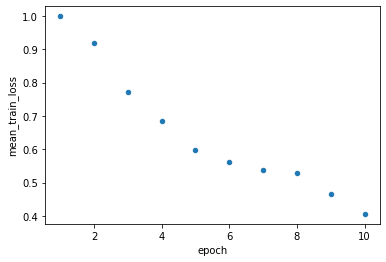

In [34]:
df_perf.plot.scatter(x='epoch', y='mean_train_loss', style='b')

The `desire_ratio` is also interesting since it tells us how many desirable molecules the model generated in the given epoch:

<AxesSubplot:xlabel='epoch', ylabel='desire_ratio'>

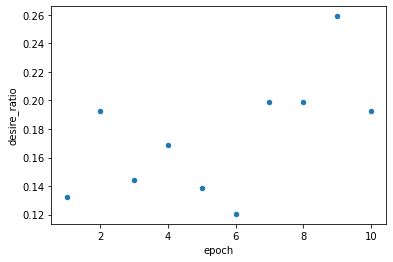

In [36]:
df_perf.plot.scatter(x='epoch', y='desire_ratio', style='b')

As we can see, our model is not very stable in this regard, but it seems that desirability tends to increase overall.

More insight can also be gained from the generated `.tsv` file with the modified scores, structures and input fragments for the generated validation molecules at each epoch:

In [38]:
df_valid = pd.read_table('data/models/reinforced/graph/agent_smiles.tsv')
df_valid.head()

,Epoch,Smiles,A1_<class 'sklearn.ensemble._forest.RandomForestRegressor'>,A2_<class 'sklearn.ensemble._forest.RandomForestRegressor'>,logP,MW,DESIRE,VALID,Frag
0,1,COc1ccc(-c2ccc(C(=O)N3CCN(C=O)C(C)C3)o2)cc1,1.000,0.884,1.000,1.000,0.0,1.0,C=O.c1ccccc1.c1ccoc1
1,1,Nc1sc2c(c1C(=O)c1cccc3ccccc13)CCCC2,1.000,0.949,0.703,1.000,0.0,1.0,Nc1cc2c(s1)CCCC2.c1ccc2ccccc2c1
2,1,CCOc1cc(C(CC(=O)O)NC(=O)C2CCCC(NC(=O)OC3=CC(C(...,0.817,1.000,0.000,0.629,0.0,1.0,FC(F)F
3,1,CC(=O)CN1CCN(c2nc(-c3cc[nH]n3)n3ccnc3n2)C(C)C1,1.000,0.835,1.000,1.000,0.0,1.0,CC(C)=O.c1cn2cncnc2n1
4,1,CC1=C(C=O)C(c2ccc(Cl)s2)C(C(=O)OC2=C(Cl)C(=NC(...,1.000,0.777,0.000,0.824,0.0,1.0,CC1=C(C=O)CC(C=O)=C(C)N1


In [39]:
df_valid.tail()

,Epoch,Smiles,A1_<class 'sklearn.ensemble._forest.RandomForestRegressor'>,A2_<class 'sklearn.ensemble._forest.RandomForestRegressor'>,logP,MW,DESIRE,VALID,Frag
1600,10,CCCC(=C(OCC1CNC(C)C1)c1ccccc1)C(c1cn[nH]c1)c1c...,1.000,0.936,0.000,1.0,0.0,1.0,C1CCNC1.Cc1ccco1.c1cncnc1
1601,10,CC1CC(=O)C1C(NC(=O)c1cc(Br)cc(Br)c1N)c1ccccc1,0.927,0.824,0.755,1.0,0.0,1.0,Nc1ccc(Br)cc1Br
1602,10,CC(C)N1CCCC1c1ncnc(-c2nccn2O)c1Cc1ccc(CC2CCNC2)o1,0.953,0.952,1.000,1.0,0.0,1.0,C1CCNC1.Cc1ccco1.c1cncnc1
1603,10,C(=Nc1nc(-c2ccoc2)nc2ncnn12)N1CCCC1,1.000,0.936,1.000,1.0,0.0,1.0,C1CCNC1.Nc1ncnc2ncnn12.c1ccoc1
1604,10,O=C1OCC=COC1=Cc1ccc(-c2c(F)cc(F)cc2F)o1,1.000,0.717,1.000,1.0,0.0,1.0,Fc1cc(F)cc(F)c1.c1ccoc1
